In [1]:
import pandas as pd
import pickle
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz
from causallearn.search.ScoreBased.GES import ges
from causallearn.score.LocalScoreFunction import local_score_BIC
from causallearn.utils.GraphUtils import GraphUtils
import io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pydot 
#Import for modification of ges 
from typing import Optional, List, Dict, Any
from numpy import ndarray
from causallearn.graph.GeneralGraph import GeneralGraph
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.GESUtils import *
from causallearn.utils.PDAG2DAG import pdag2dag

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

#import causalGenTool
from CGT.core.utils import show
from CGT.patch.causalLearnPatch import ges_updated
from CGT.core.generator import CausalGenerator, norm_col, KL
from CGT.core.discovery import Discoverer
from CGT.core.bias import Observer
from CGT.core.assessment import Assessor

/home/maxence/anaconda3/envs/causal-learn-test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creation of Synthetic Dataset

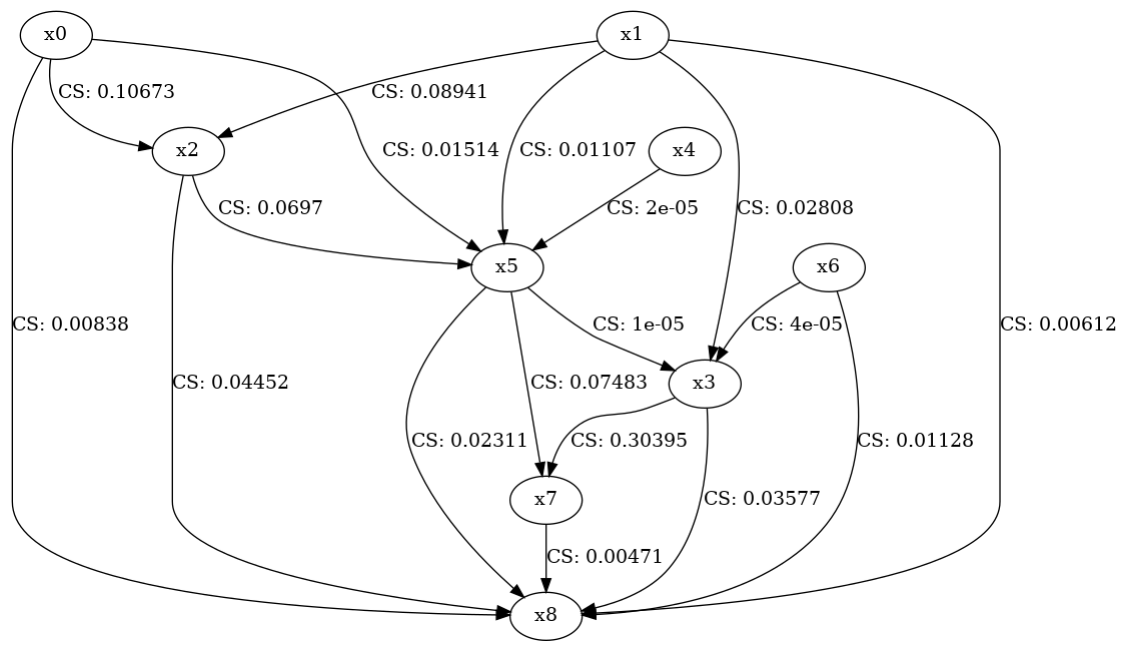

In [2]:
var_names = ['Sex', 'Age', 'Job', 'Credit_Amount','Housing',\
            'Wealth','Purpose','Duration','Credit_Score']
adj = np.array([[0, 0, -6, 0, 0, 1, 0, 0, -2], \
                [0, 0, -4, 1, 0, 1, 0, 0, -2], \
                [0, 0, 0, 0, 0, -5, 0, 0, 5],
                [0, 0, 0, 0, 0, 0, 0, 5, -5],
                [0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 3, 0, 0, 0, -3, -4],
                [0, 0, 0, -7, 0, 0, 0, 0, 3],
                [0, 0, 0, 0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 0, 0, 0, 0, 0]])

test = CausalGenerator(adj, var_names=None, size=100000, normalize=False)
test.graph_from_adjacency_matrix(directed=True)
test.generate_data()
#print(test.data.head())
#sample_ = pd.read_csv('./fairness/Fred/Test/synthetic_data.csv')
#sample_.drop('Unnamed: 0', axis='columns', inplace=True)
#test.data= sample_
test.compute_CPDs()
test.allEdgesCausalStrength()
#test.allEdgesCausalStrength_v2()
#test.isBayesianNetwork()
#test.save()
#assessor1 = Assessor(sensible_parameter='x0', output_variable='x8', data=test.data, bias=None)
#assessor1.compute_fairness(metrics=['statistical_parity'])
test.show_graph()

### (Optionnal), compute Stability Score

In [ ]:
for i in range(50):
    observer = Observer(test.data, 'x0')
    sample = observer.observe(bias=None, n_data=10000)
    alg ='pc'
    pc_param = {'alpha' : [0.05], 'indep_test':[gsq]}
    discoverer2 = Discoverer()
    discoverer2.grid_search(sample.to_numpy(), alg, pc_param, test.graph)
    
true_graph = discoverer2.grid_search_results()
for i in range(len(discoverer2.discovered_graphs_pyd)):
    discoverer2.discovered_graphs_pyd[-1].write_png('./outputs/stability2/graph'+str(i)+'.png')

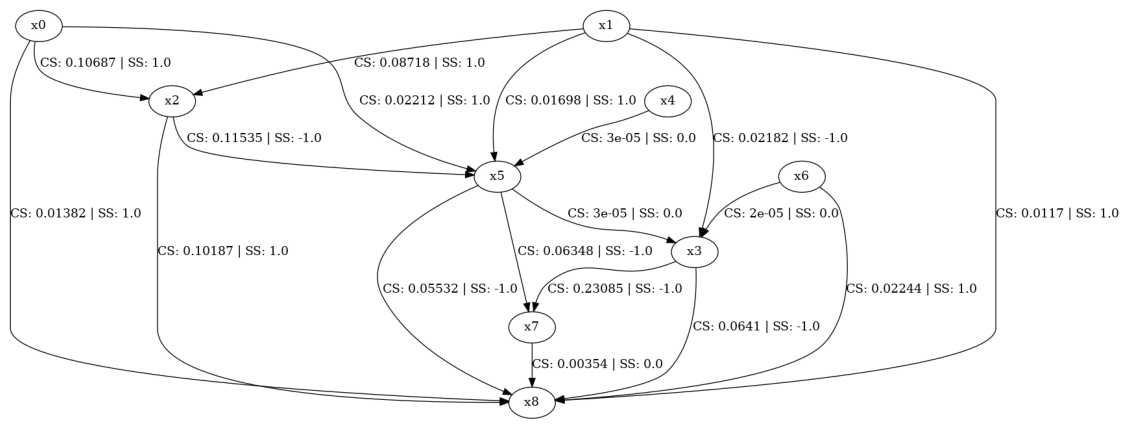

In [160]:
show(discoverer2.gs_true_graph)

## Fetch sample and add bias to it

In [3]:
probs = {
    'keys':['x0','x8'],
    'values': (1,1),
    'prob': 0.7
}
#probs2 = {
    #'keys':['x0','x1','x2','x8'],
    #'values': (1,1,1,1),
    #'prob': 0.7
#}
#conds = [probs, probs2]
conds = [probs]
observer = Observer(test.data, 'x0')
sample = observer.observe(bias=conds, n_data=10000, debug=True)


0.19369187221997575
0.19389405580266883
0.1940962393853619
0.19429842296805502
0.19450060655074808
0.19470279013344116
0.19490497371613424
0.19510715729882736
0.19530934088152044
0.1955115244642135
0.1957137080469066
0.1959158916295997
0.19611807521229277
0.19632025879498585
0.19652244237767894
0.19652244237767894
0.19672462596037202
0.1969268095430651
0.1971289931257582
0.1973311767084513
0.19753336029114435
0.19773554387383746
0.19793772745653054
0.19813991103922363
0.1983420946219167
0.1985442782046098
0.19874646178730287
0.19894864536999596
0.19915082895268907
0.19935301253538212
0.1995551961180752
0.1997573797007683
0.1999595632834614
0.20016174686615448
0.20036393044884754
0.20056611403154065
0.20076829761423373
0.20097048119692681
0.20117266477961993
0.20137484836231298
0.20157703194500606
0.20177921552769915
0.20198139911039226
0.20218358269308534
0.2023857662757784
0.2025879498584715
0.2027901334411646
0.20299231702385767
0.20319450060655075
0.20339668418924384
0.2035988677719

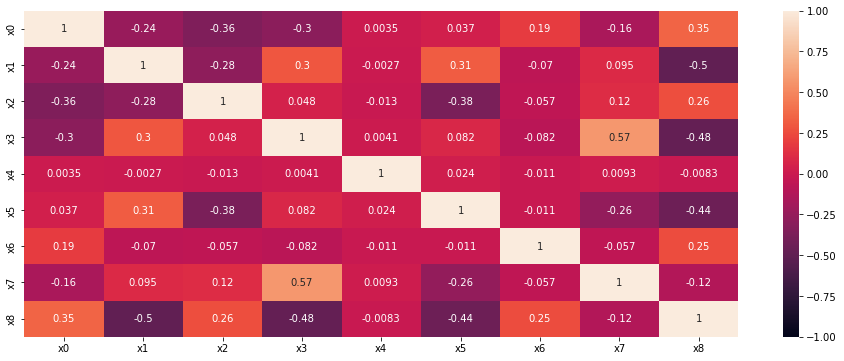

In [136]:
import seaborn as sns
plt.figure(figsize=(16, 6))
corr = sample.corr()
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

## Discovery Part

Current parameters used:  {'alpha': 0.05, 'indep_test': <function gsq at 0x7f9dec6d6e50>}


Depth=5, working on node 8: 100%|██████████| 9/9 [00:00<00:00, 275.99it/s] 


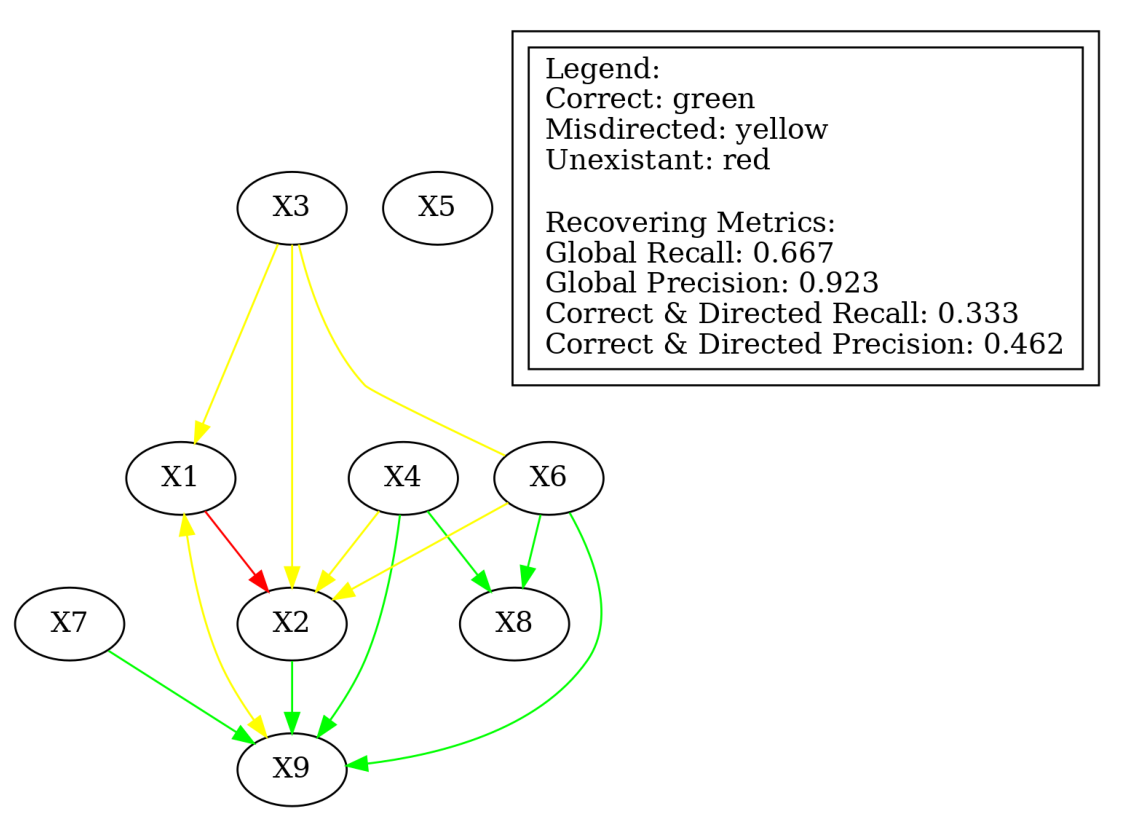

In [4]:
alg ='pc'
pc_param = {'alpha' : [0.05], 'indep_test':[gsq]}
discoverer2 = Discoverer()
discoverer2.grid_search(sample.to_numpy(), alg, pc_param, test.graph)
#alg ='ges'
#ges_param = {'score_func' : ['local_score_BIC','local_score_BDeu'], 'maxP' : [None]}
#discoverer2.grid_search(test.data.to_numpy(), alg, ges_param, test.graph)
true_graph = discoverer2.grid_search_results()
show(discoverer2.discovered_graphs_pyd[0])

Current parameters used:  {'score_func': 'local_score_BIC', 'maxP': None}
x0
x1
x2
x3
x4
x5
x6
x7
x8
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]
x0
x1
x2
x3
x4
x5
x6
x7
x8
[[ 0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]]
x0
x1
x2
x3
x4
x5
x6
x7
x8
x3
[[ 0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1]
 [ 0  0  0 -1  0  0  0  0  0]
 [-1  0  0  0  0  0  1  0  0]]
x0
x1
x2
x3
x4
x5
x6
x7
x8
x0

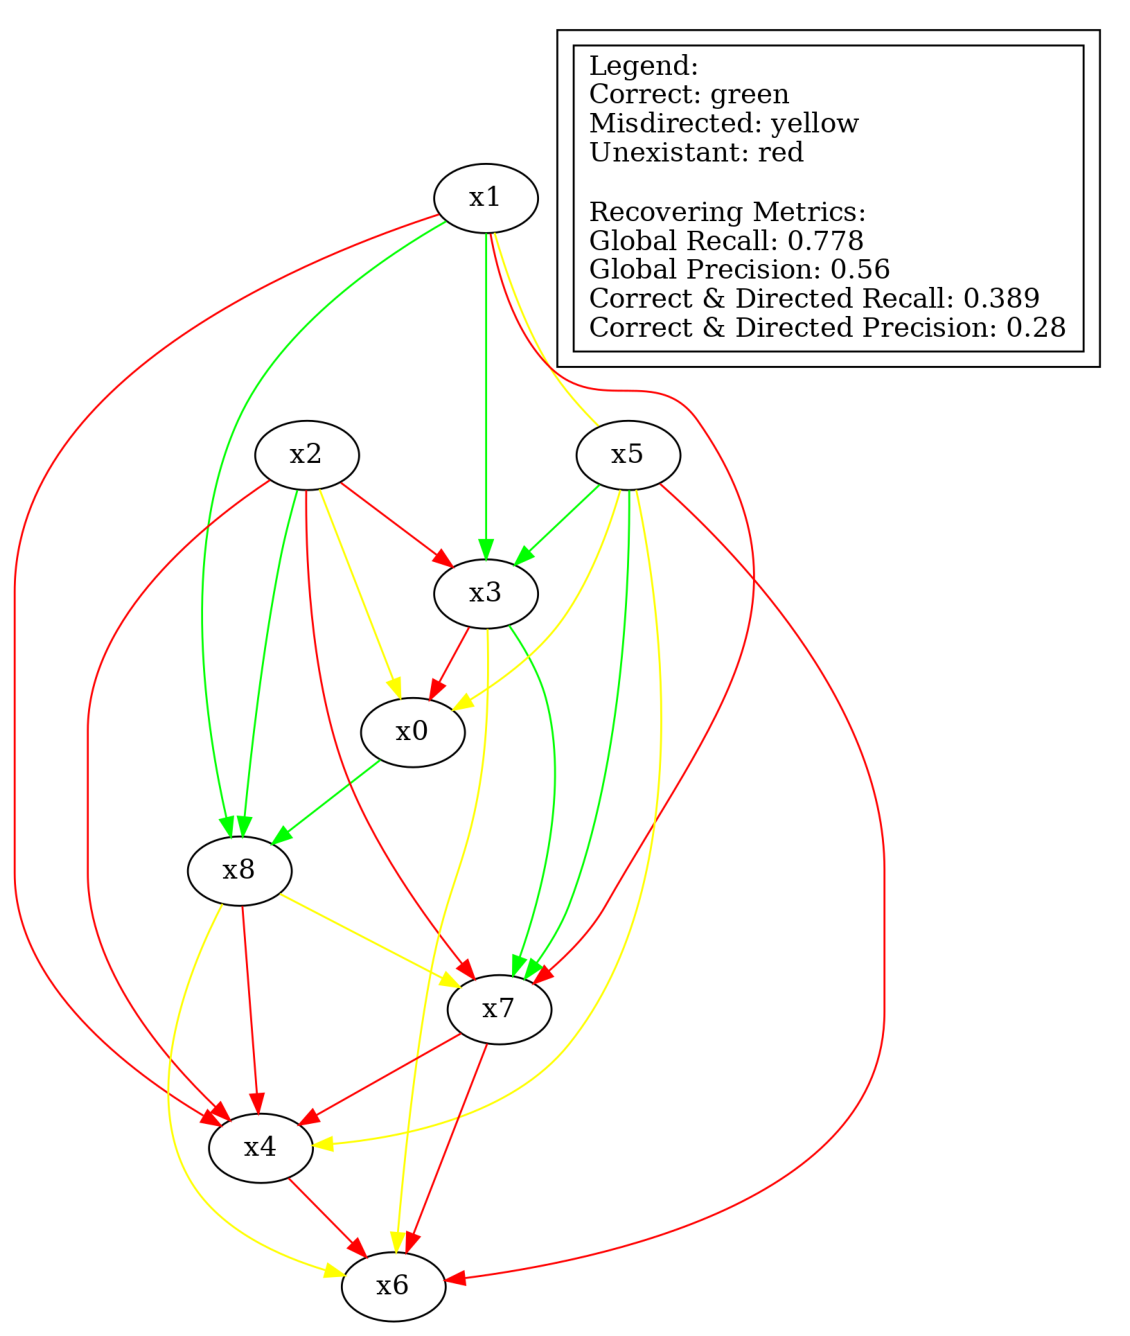

In [5]:
#alg ='pc'
#pc_param = {'alpha' : [0.05], 'indep_test':[gsq]}
discoverer2 = Discoverer()
#discoverer2.grid_search(sample.to_numpy(), alg, pc_param, test.graph)
alg ='ges'
ges_param = {'score_func' : ['local_score_BIC'], 'maxP' : [None]}
discoverer2.grid_search(sample.to_numpy(), alg, ges_param, test.graph)
true_graph = discoverer2.grid_search_results()
show(discoverer2.discovered_graphs_pyd[-1])

## Prediction part

In [6]:
#Init
from imblearn.under_sampling import RandomUnderSampler
X = sample.iloc[:,:-1]
y = sample['x8']

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X, y)

In [7]:
X_pc1 = X_res[['x4','x6']]
X_pc2 = X_res[['x4','x6','x5']]
X_pc3 = X_res[['x1','x2','x5']]
X_pc4 = X_res[['x3','x4','x7']]
X_pc5 = X_res[['x4','x6','x1']]
#X_pc2 = X_res[['x6','x4', 'x5']]
X_ges = X_res[['x2']]

datasets = [X_pc1, X_pc2, X_pc3, X_pc4, X_pc5, X_ges]

In [8]:
assessor1 = Assessor('x0', 'x8', test.data, bias= conds)
scores_real = assessor1.compute_fairness(['statistical_parity','KL_fairness'], ['x1','x2','x3','x4','x5','x6','x7'])
print("REAL WORLD: ", scores_real)
#observer.describe(sample, CSP=conds)
for idx, dataset in enumerate(datasets):
    assessor2 = Assessor('x0', 'x8', sample, bias= conds)
    print("[{}] EXTRACTED WORLD: ".format(idx),assessor2.compute_fairness(['statistical_parity','KL_fairness'], list(dataset.columns)))

REAL WORLD:  {'statistical_parity': -0.18960428639854285, 'KL_fairness': 1.0881908357543595}
[0] EXTRACTED WORLD:  {'statistical_parity': 0.3208582249033527, 'KL_fairness': 0.2228795996408547}
[1] EXTRACTED WORLD:  {'statistical_parity': 0.3208582249033527, 'KL_fairness': 0.34503641881723035}
[2] EXTRACTED WORLD:  {'statistical_parity': 0.3208582249033527, 'KL_fairness': 0.8380969630537222}
[3] EXTRACTED WORLD:  {'statistical_parity': 0.3208582249033527, 'KL_fairness': 0.2495795304990849}
[4] EXTRACTED WORLD:  {'statistical_parity': 0.3208582249033527, 'KL_fairness': 0.23856240663971795}
[5] EXTRACTED WORLD:  {'statistical_parity': 0.3208582249033527, 'KL_fairness': 0.7691062747566195}


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from tqdm import tqdm
#Selection

skf = StratifiedKFold(n_splits=10)

probs = {
    'keys':['x0','Output'],
    'values': (1,1),
    'prob': 0.7
}

store = []
#probs2 = {
    #'keys':['x0','x1','x2','x8'],
    #'values': (1,1,1,1),
    #'prob': 0.7
#}
#conds = [probs, probs2]
conds = [probs]

metrics = ['statistical_parity', 'overall_accuracy', 'KL_fairness']
records  = {key: []  for key in metrics}
method = {}
for idx, dataset in enumerate(datasets):
    records  = {key: []  for key in metrics}
    for train_index, test_index in skf.split(dataset, y_res):
        X_train = dataset.loc[train_index,:]
        y_train = y_res.loc[train_index]
        X_test = dataset.loc[test_index,:]
        y_test = y_res.loc[test_index]
        clf = LogisticRegression(random_state=0).fit(X_train, y_train)

        for i in tqdm(range(1000)):
            
            X_val, y_val = resample(X_test, y_test, random_state=i)
            outputs = clf.predict(X_val)
            output_df = X.iloc[X_val.index].copy()
            output_df['Output'] = outputs
            output_df['x8'] = y.iloc[y_val.index].copy()
            store.append(output_df)
            assessor = Assessor(sensible_parameter='x0', output_variable='Output', data=output_df, bias = conds)
            record = assessor.compute_fairness(metrics=metrics, extracted_var=list(dataset.columns))

            for key in list(record.keys()):
                records[key].append(record[key])
                
    method[idx] = records

100%|██████████| 1000/1000 [00:24<00:00, 40.60it/s]


In [10]:
def compare_boxplot(record_real, records_method):

    assert isinstance(records_method, dict), 'expected dict of records, one for each method'
    assert isinstance(record_real, dict), 'expected record in dict format'

    for key in records_method[0]:
        _, ax = plt.subplots(figsize=(10,10))
        boxplot_stat = {key+'_meth{}'.format(idx): records_method[idx][key] for idx in list(records_method.keys())}
        if key in record_real: plt.plot([record_real[key] for i in range(len(records_method)+2)], color='red')
        pd.DataFrame.from_dict(boxplot_stat).boxplot(ax=ax)

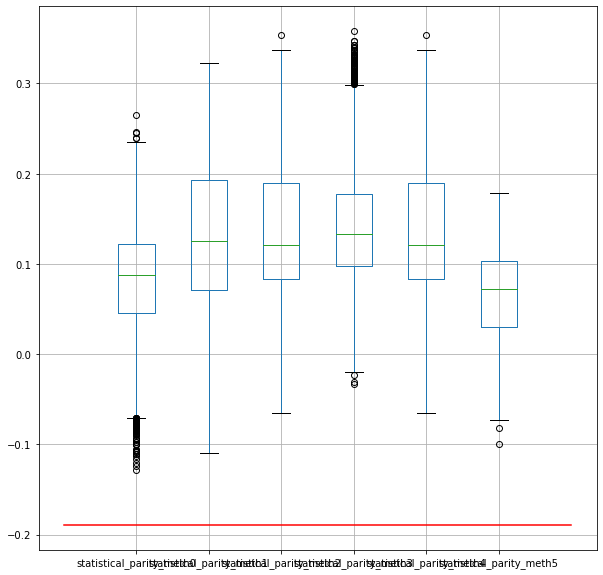

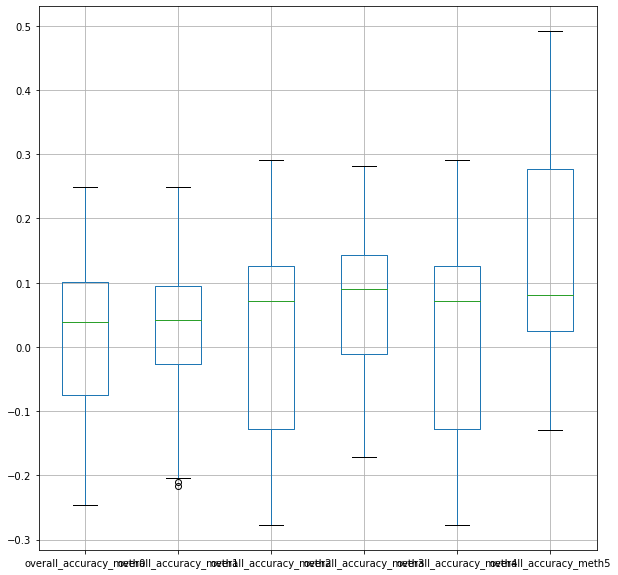

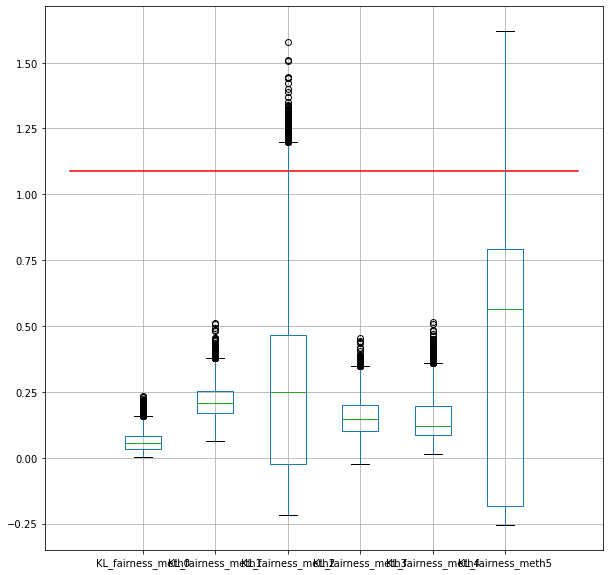

In [11]:
compare_boxplot(scores_real, method)